In [14]:
from nltk.corpus import stopwords
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
import os


In [15]:
df_movies = pd.read_csv('../../data/MovieSummaries/movies_metadata_cleaned.csv')
# Rename column Movie_release_date to year
df_movies.rename(columns={'Movie_release_date': 'year', 'Wikipedia_movie_ID': 'movie_id'}, inplace=True)

# Remove all rows with missing values in the year column
df_movies = df_movies.dropna(subset=['year'])

# Filter out movies with year between 1930 and 2015
df_movies = df_movies[df_movies['year'] >= 1930]

print(df_movies.head())


   Unnamed: 0.1  Unnamed: 0  movie_id Freebase_movie_ID  \
0             0           0    975900         /m/03vyhn   
1             1           3   9363483        /m/0285_cd   
2             2           4    261236         /m/01mrr1   
3             3           6  18998739        /m/04jcqvw   
4             4          12   6631279         /m/0gffwj   

                  Movie_name    year  Movie_box_office_revenue  Movie_runtime  \
0             Ghosts of Mars  2001.0                14010832.0           98.0   
1           White Of The Eye  1987.0                       NaN          110.0   
2          A Woman in Flames  1983.0                       NaN          106.0   
3  The Sorcerer's Apprentice  2002.0                       NaN           86.0   
4                Little city  1997.0                       NaN           93.0   

        Movie_languages               Movie_countries  \
0  ['English Language']  ['United States of America']   
1  ['English Language']            ['United 

In [16]:

plot_summary_df = pd.read_csv('../../data/MovieSummaries/plot_summaries_cleaned.csv')
plot_summary_df.columns = ['movie_id', 'plot_summary']
plot_summary_df = plot_summary_df.set_index('movie_id')

# Add year to the plot_summary_df
plot_summary_df = plot_summary_df.join(df_movies.set_index('movie_id'), on='movie_id')
plot_summary_df = plot_summary_df[['year', 'plot_summary']]
# Drop rows with missing values in the plot_summary or year column
plot_summary_df = plot_summary_df.dropna(subset=['plot_summary', 'year'])

# Convert year to integer
plot_summary_df['year'] = plot_summary_df['year'].astype(int)

print(plot_summary_df.head())
print(plot_summary_df.shape)


          year                                       plot_summary
movie_id                                                         
23890098  1990  Shlykov hardworking taxi driver Lyosha saxopho...
31186339  2012  nation Panem consists wealthy Capitol twelve p...
20663735  2000  Poovalli Induchoodan sentenced six years priso...
2231378   1951  Lemon Drop Kid New York City swindler illegall...
595909    1988  Seventhday Adventist Church pastor Michael Cha...
(38276, 2)


In [17]:
# Load the model
model_miniLM = SentenceTransformer("all-MiniLM-L6-v2")
GPUS_DEVICE = 'mps'

In [18]:
# Load embedding or compute if not available

if os.path.exists('movies_embeddings.npy'):
    movies_embeddings = np.load('movies_embeddings.npy')
    movies_embeddings = torch.tensor(movies_embeddings).to(GPUS_DEVICE)

else:
    movies_embeddings = model_miniLM.encode(plot_summary_df['plot_summary'].values, show_progress_bar=True, convert_to_tensor=True)
    np.save('movies_embeddings.npy', movies_embeddings.to('cpu').numpy())

print(movies_embeddings.shape)

Batches: 100%|██████████| 1197/1197 [02:23<00:00,  8.36it/s]


torch.Size([38276, 384])


In [19]:
# Raw queries to encode
# Queries
VIETNAM_WAR = "Vietnam"
COLD_WAR = "USSR"
IRAK_WAR = "Irak"
WW2 = "World War 2"
TECHNOLOGY = "technology"
ECONOMY = "economy"
HEALTH = "health"
GENDER_EQUALITY = "gender equality"
MIGRATION = "migration"

# Encode queries
query_vietnam = torch.tensor(model_miniLM.encode([VIETNAM_WAR])).to(GPUS_DEVICE)
query_cold_war = torch.tensor(model_miniLM.encode([COLD_WAR])).to(GPUS_DEVICE)
query_irak_war = torch.tensor(model_miniLM.encode([IRAK_WAR])).to(GPUS_DEVICE)
query_ww2 = torch.tensor(model_miniLM.encode([WW2])).to(GPUS_DEVICE)

query_technology = torch.tensor(model_miniLM.encode([TECHNOLOGY])).to(GPUS_DEVICE)
query_economy = torch.tensor(model_miniLM.encode([ECONOMY])).to(GPUS_DEVICE)
query_health = torch.tensor(model_miniLM.encode([HEALTH])).to(GPUS_DEVICE)
query_gender_equality = torch.tensor(model_miniLM.encode([GENDER_EQUALITY])).to(GPUS_DEVICE)
query_migration = torch.tensor(model_miniLM.encode([MIGRATION])).to(GPUS_DEVICE)

queries = [query_vietnam, query_cold_war, query_irak_war, query_ww2, query_technology, query_economy, query_health, query_gender_equality, query_migration]
column_names = ['vietnam', 'cold_war', 'irak_war', 'ww2', 'technology', 'economy', 'health', 'gender_equality', 'migration']


In [20]:
# Create a dataframe to store the cosine similarity
cosine_similarity_df = pd.DataFrame(columns=column_names)

# Add the index and year to the dataframe
cosine_similarity_df['index'] = plot_summary_df.index
cosine_similarity_df = cosine_similarity_df.set_index('index')

# Compute cosine similarity for each query
for i, query in enumerate(queries):
    similarity = torch.nn.functional.cosine_similarity(movies_embeddings, query)
    cosine_similarity_df[column_names[i]] = similarity.to('cpu').numpy()

# Add the year to the dataframe
cosine_similarity_df['year'] = plot_summary_df['year']
print(cosine_similarity_df.head())
print(cosine_similarity_df.shape)

           vietnam  cold_war  irak_war       ww2  technology   economy  \
index                                                                    
23890098  0.089712  0.133718  0.066871  0.066404    0.084017  0.057000   
31186339  0.134952  0.065855  0.159707  0.089287    0.031679  0.090338   
20663735  0.058104  0.056550  0.065674 -0.021893    0.032418  0.034638   
2231378   0.011053  0.036683  0.066888 -0.002780   -0.014954  0.079014   
595909    0.057968 -0.065509  0.061956 -0.030080   -0.058504 -0.061991   

            health  gender_equality  migration  year  
index                                                 
23890098  0.068972         0.095690   0.009648  1990  
31186339  0.055247         0.071051   0.066095  2012  
20663735  0.027445         0.153299   0.067044  2000  
2231378   0.012682         0.070651   0.036011  1951  
595909    0.029426         0.032958   0.006741  1988  
(38276, 10)


In [21]:
# Save the dataframe
cosine_similarity_df.to_csv('../../data/df_movies/cosine_similarity_movies.csv', index=True)
# Make a boolean version of the dataframe with a threshold of 0.3
cosine_similarity_df_bool = cosine_similarity_df.copy()
cosine_similarity_df_bool = cosine_similarity_df_bool.drop(columns=['year'])
cosine_similarity_df_bool = cosine_similarity_df_bool > 0.2
cosine_similarity_df_bool['year'] = cosine_similarity_df['year']

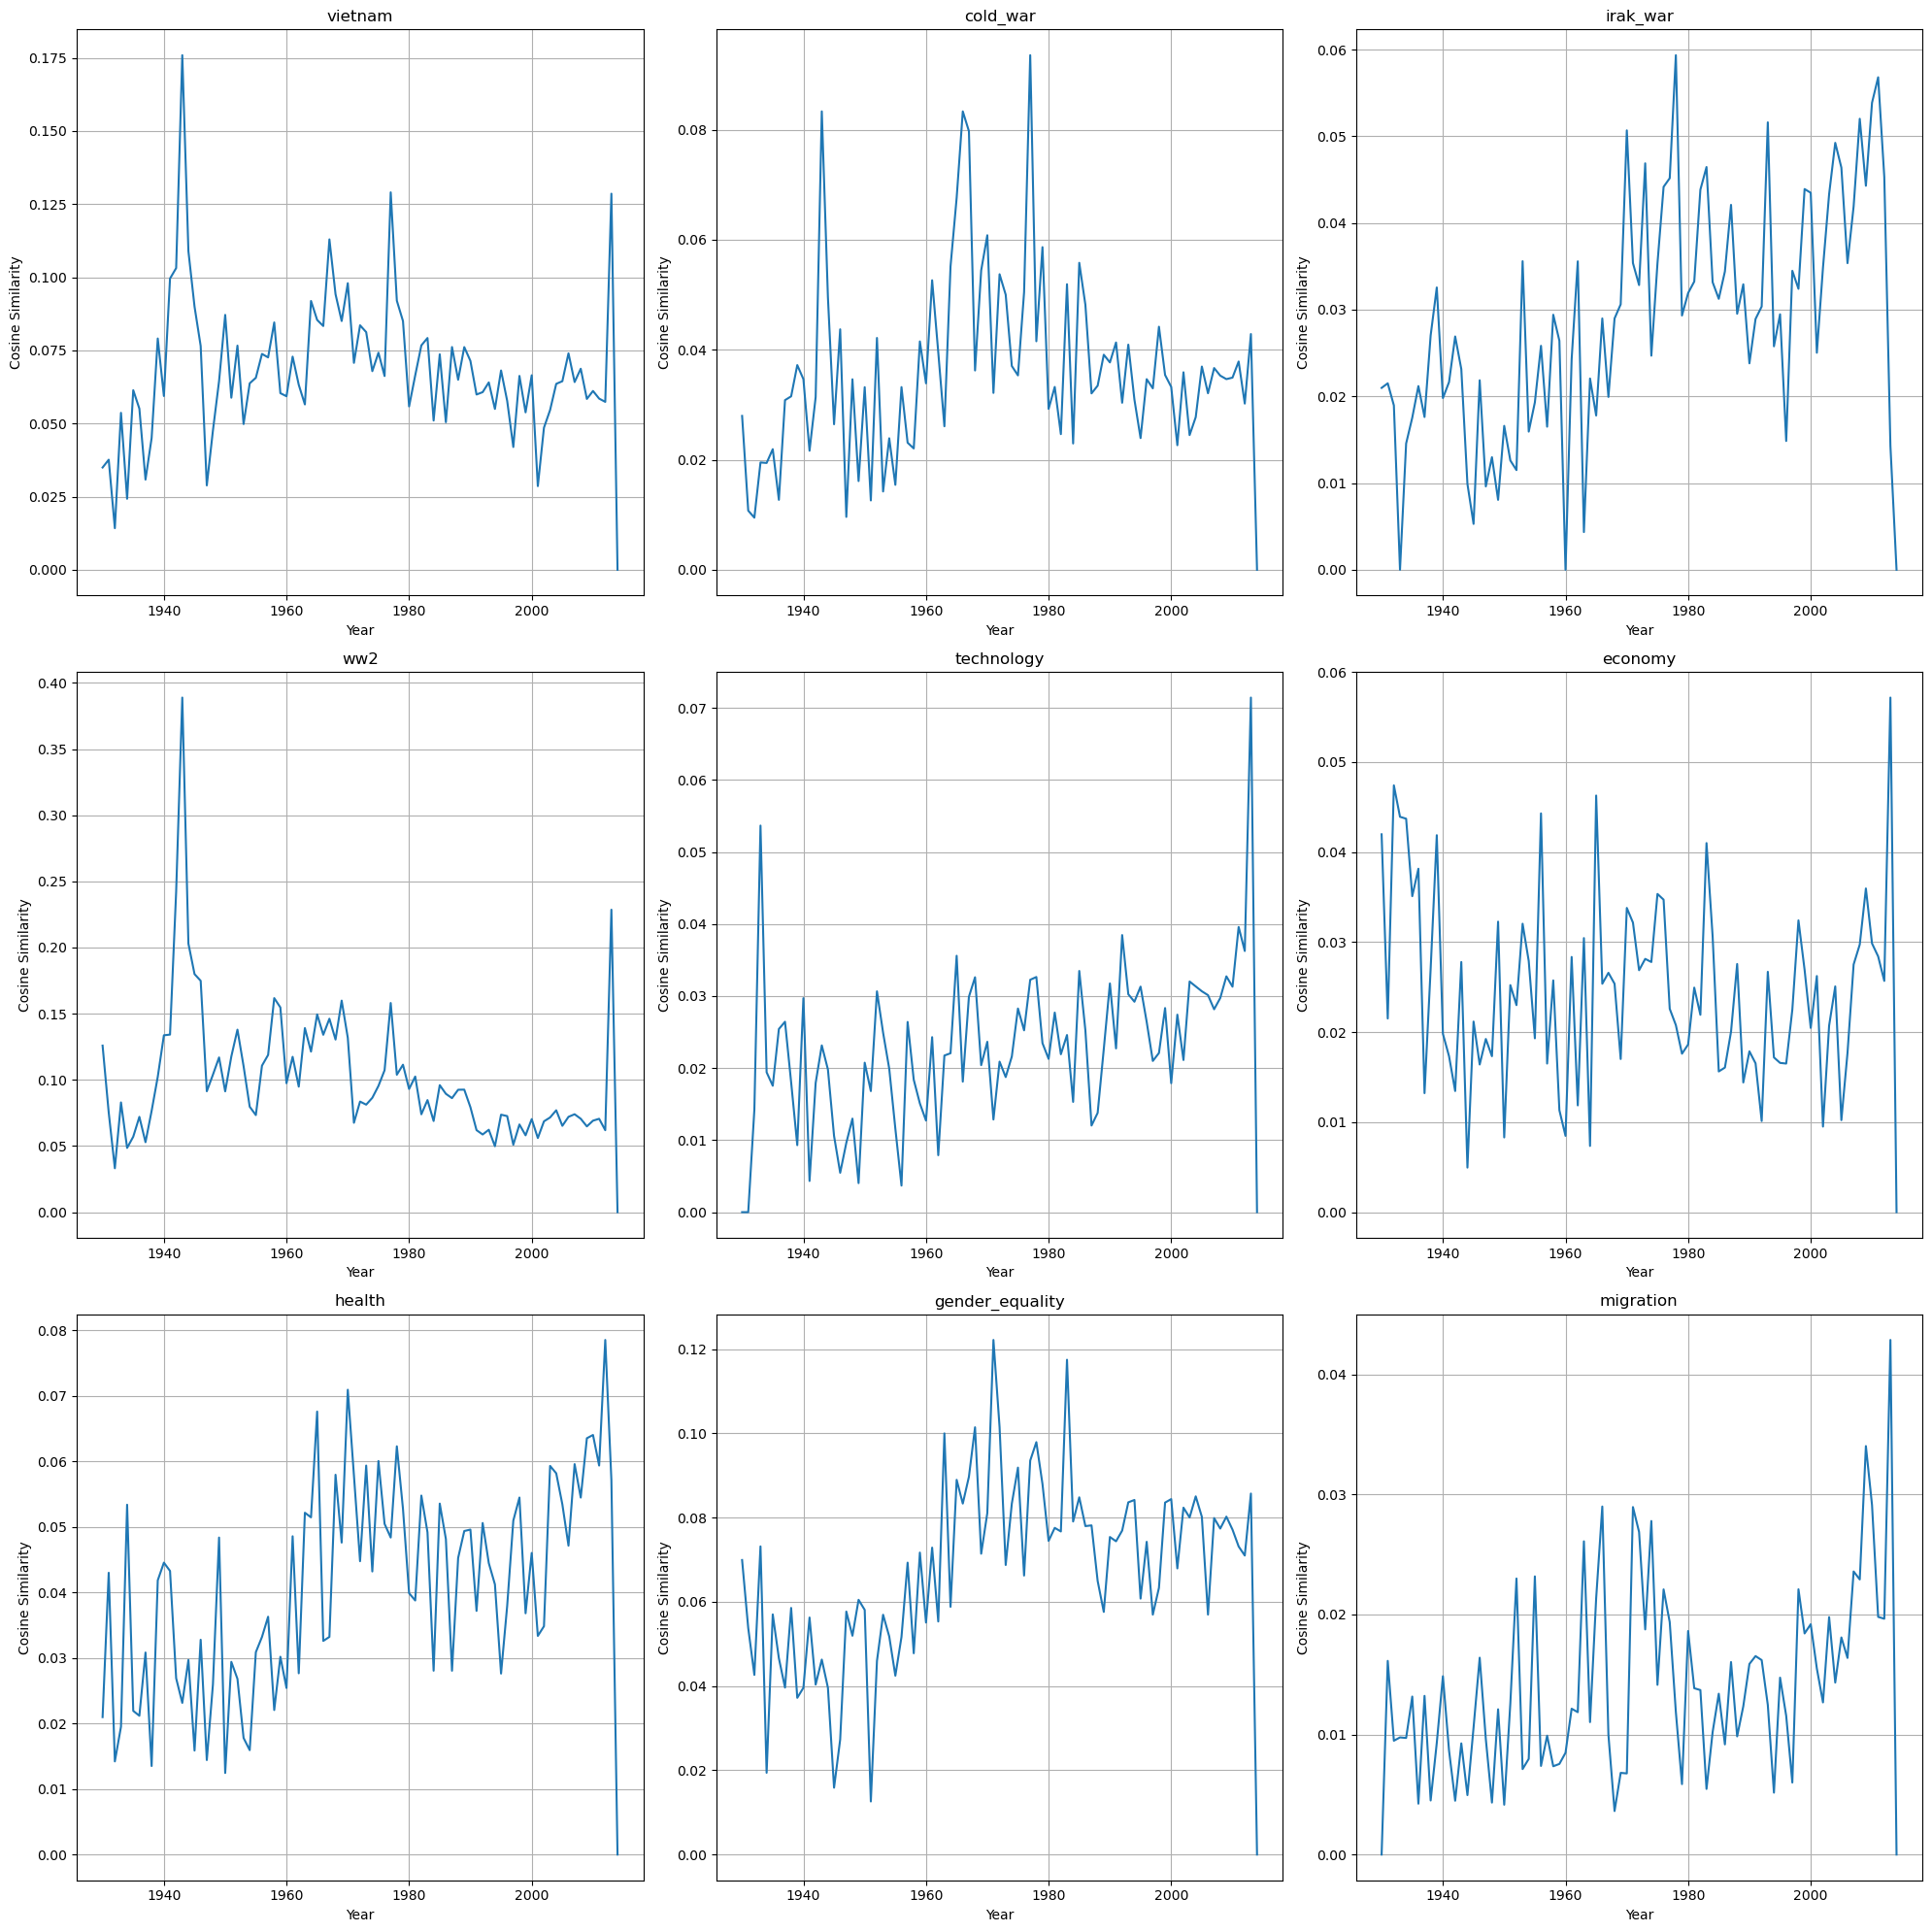

In [22]:
# Number of articles per year
articles_per_year = plot_summary_df['year'].value_counts()
# Plot the cosine similarity for each query over time

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for i, column in enumerate(column_names):
    row = i // 3
    col = i % 3
    # Sum the boolean values for each year
    cosine_similarity_df_bool_grouped = cosine_similarity_df_bool.groupby('year').sum()
    # Normalize the values by the number of articles in the year
    cosine_similarity_df_bool_grouped = cosine_similarity_df_bool_grouped.div(articles_per_year, axis=0)
    ax[row, col].plot(cosine_similarity_df_bool_grouped.index, cosine_similarity_df_bool_grouped[column])
    ax[row, col].set_title(column)
    ax[row, col].set_xlabel('Year')
    ax[row, col].set_ylabel('Cosine Similarity')
    ax[row, col].grid()
plt.tight_layout()
plt.savefig('../../figures/movies/cosine_similarity_movies.png')

plt.show()